In [1]:
import crocoddyl
import pinocchio
from IPython.display import HTML
import mim_solvers
import numpy as np

In [2]:
from matplotlib import animation
from matplotlib import pyplot as plt


def animatePointMass(xs, sleep=50, show=False):
    print("processing the animation ... ")
    mass_size = 1.0
    fig = plt.figure()
    ax = plt.axes(xlim=(-2, 12), ylim=(-2, 12))
    patch = plt.Circle((0, 0), radius=0.2, fc="b")
    time_text = ax.text(0.02, 0.95, "", transform=ax.transAxes)

    def init():
        ax.add_patch(patch)
        time_text.set_text("")
        return patch, time_text

    def animate(i):
        x_pm = xs[i][0]
        y_pm = xs[i][1]
        patch.set_center((x_pm, y_pm))
        time = i * sleep / 1000.0
        time_text.set_text(f"time = {time:.1f} sec")
        return patch, time_text

    anim = animation.FuncAnimation(
        fig, animate, init_func=init, frames=len(xs), interval=sleep, blit=True
    )
    print("... processing done")
    if show:
        plt.show()
    return anim

In [3]:
class DifferentialActionModelPointMass(crocoddyl.DifferentialActionModelAbstract):
    def __init__(self):
        crocoddyl.DifferentialActionModelAbstract.__init__(
            self, crocoddyl.StateVector(4), 2, 4
        )  # nu = 2 {Fx, Fy}; nr = 3 {3 Gaussians, 1 Translation}
        
        self.unone = np.zeros(self.nu)
        self.m = 1.0
        self.costWeights = [
            100.0
        ]

    def calc(self, data, x, u=None):
        if u is None:
            u = self.unone
        # Getting the state and control variables
        X, Y, Xdot, Ydot = x[0], x[1], x[2], x[3]
        fx = u[0]
        fy = u[1]

        # Shortname for system parameters
        m = self.m

        # Defining the equation of motions
        xddot = fx / m
        yddot = fy / m
        data.xout = np.matrix([xddot, yddot]).T

        # Cost parameters (Translation + Obstacle)
        target = np.array([10, 0, 0, 0])
        # obs_center = np.array([5, 0])
        # obs_rad = 2.0

        trans_r = np.linalg.norm(target - x)
        # obs_r = np.sqrt(np.sum((x[:2] - obs_center)*(x[:2] - obs_center)))- obs_rad
        # Computing the cost residual and value
        # data.r = np.matrix(self.costWeights * np.array([obs_r, trans_r])).T
        data.r = np.matrix(self.costWeights * np.array([trans_r])).T
        data.cost = 0.5 * sum(np.asarray(data.r) ** 2)


In [4]:
PM_DAM = DifferentialActionModelPointMass()
pmData = PM_DAM.createData()
x = np.array([0, 0, 0, 0])
u = np.zeros(2)
PM_DAM.calc(pmData, x, u)

In [5]:
PM_ND = crocoddyl.DifferentialActionModelNumDiff(PM_DAM, False)

In [6]:
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND, timeStep)

In [7]:
x0 = np.array([0.0, 0.0, 0.0, 0.0])
u0 = np.array([0.0, 0.0])
T = 100
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM)

In [8]:
# Creating the SQP solver
sqp = mim_solvers.SolverSQP(problem)
sqp.setCallbacks([crocoddyl.CallbackVerbose()])
sqp.with_callbacks=True
sqp.termination_tolerance = 1e-4
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]

# Solving this problem
done = sqp.solve(xs_init, us_init, 100)
print(done)
print(sqp.us)

iter     merit         cost         grad      step    ||gaps||        KKT
   1  3.00000e+06  3.00000e+06  1.38497e+01  1.0000  0.00000e+00  9.93008e+04
   2  5.12657e+05  5.12657e+05  1.89545e-06  1.0000  4.71845e-14  6.77986e-03
   3  5.12657e+05  5.12657e+05  7.03659e-07  0.5000  5.48129e-14  1.23165e-04
   4  5.12657e+05  5.12657e+05  8.39179e-07  1.0000  6.80207e-14  1.52761e-04
True END  5.12657e+05  5.12657e+05  9.07305e-07   ----   5.18596e-14  9.15612e-05



processing the animation ... 
... processing done


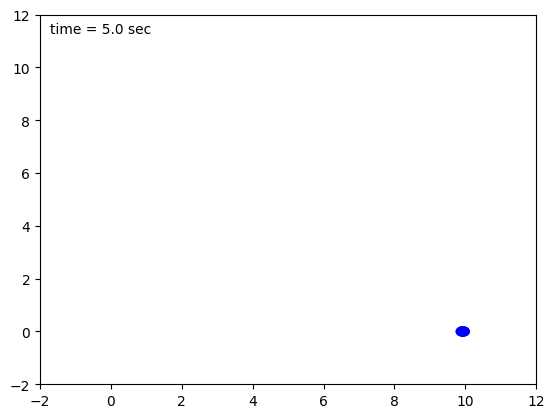

In [9]:
HTML(animatePointMass(sqp.xs).to_jshtml())

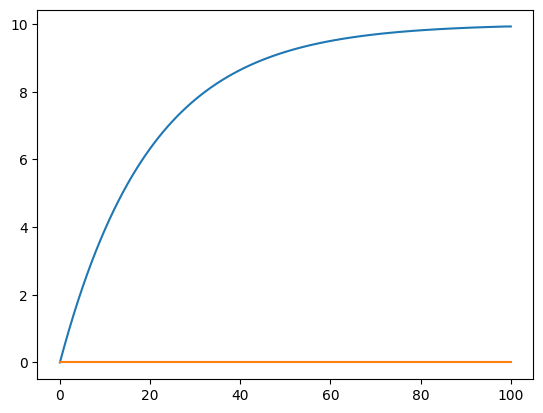

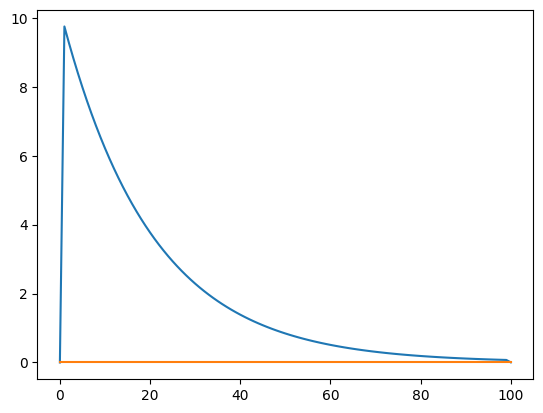

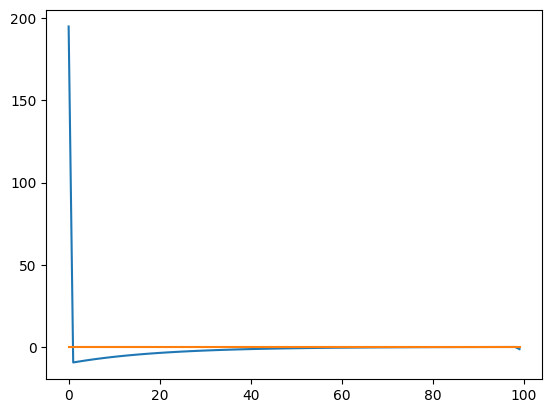

In [10]:
Xs = np.stack(sqp.xs.tolist())
Us = np.stack(sqp.us.tolist())

plt.plot(Xs[:,0])
plt.plot(Xs[:,1])
plt.show()

plt.plot(Xs[:,2])
plt.plot(Xs[:,3])
plt.show()

plt.plot(Us[:,0])
plt.plot(Us[:,1])
plt.show()